# BP神经网络训练MNIST&CIFAR-10

## BP神经网络类

In [1]:
import numpy as np


# 激活函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# 求导
def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    max_x = np.max(x,axis=1,keepdims=True)
    exps = np.exp(x-max_x)
    return exps / np.sum(exps,axis=1,keepdims=True)


# 全局误差
def mean_squared_error(y_true, y_pred):
    return np.mean(np.sum((y_true - y_pred) ** 2,axis=1,keepdims=True))
    # return np.mean((y_true - y_pred) ** 2)
    
# 损失函数
def cross_entropy_loss(y_true, y_pred):
    # Avoiding numerical instability
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred)) / len(y_true)


# 第i隐含层有pi个神经元,输出层有q个神经元
class BP:
    def __init__(self, input_size, p, q):
        '''
        input_size: int 输入层变量的形状（扁平化）
        p: List 隐藏层，[10,10,20]:三个隐藏层，分别有10，10，20个神经元数
        q: int 输出层变量的形状（扁平化）
        '''
        self.input_size = input_size
        self.p = p
        self.q = q
        self.w = []
        self.b = []
        self.layer_out = []  # 各层输出
        self.layers = len(p) + 1
        self.acc = []

        layer_sizes = [input_size] + p + [q]
        for i in range(1, self.layers + 1):
            # w = np.random.uniform(low=-1, high=1, size=(layer_sizes[i - 1], layer_sizes[i]))
            w = np.random.randn(layer_sizes[i - 1], layer_sizes[i])
            b = np.random.randn(1, layer_sizes[i])
            self.w.append(w)
            self.b.append(b)

    # 正向传播
    def forword(self, x):
        self.layer_out = []
        # 输入层
        out_put = sigmoid(np.dot(x, self.w[0]) + self.b[0])
        self.layer_out.append(out_put)
        # 隐含层
        for i in range(1,self.layers - 1):
            out_put = sigmoid(np.dot(out_put, self.w[i]) + self.b[i])
            self.layer_out.append(out_put)
        
        # 输出层
        out_put = sigmoid(np.dot(out_put, self.w[-1]) + self.b[-1])
        # out_put = softmax(np.dot(out_put, self.w[-1]) + self.b[-1])
        self.layer_out.append(out_put)
        return out_put

    # 反向传播
    def backword(self, x, y, learn_rate):
        num_samples = x.shape[0]
        # 输出误差
        output_error = y - self.layer_out[-1]
        delta = output_error * sigmoid_derivative(self.layer_out[-1])
        weight_delta = np.dot(self.layer_out[-2].T, delta)
        bias_delta = np.sum(delta, axis=0, keepdims=True)
        self.w[-1] += learn_rate * weight_delta / num_samples
        self.b[-1] += learn_rate * bias_delta / num_samples

        # 更新隐含层权值
        for i in range(self.layers - 2, 0, -1):
            output_error = np.dot(delta, self.w[i+1].T)
            delta = output_error * sigmoid_derivative(self.layer_out[i])
            weight_delta = np.dot(self.layer_out[i-1].T, delta)
            bias_delta = np.sum(delta, axis=0, keepdims=True)
            self.w[i] += learn_rate * weight_delta / num_samples
            self.b[i] += learn_rate * bias_delta / num_samples

        output_error = np.dot(delta, self.w[1].T)
        delta = output_error * sigmoid_derivative(self.layer_out[0])
        weight_delta = np.dot(x.T, delta)
        bias_delta = np.sum(delta, axis=0, keepdims=True)
        self.w[0] += learn_rate * weight_delta / num_samples
        self.b[0] += learn_rate * bias_delta / num_samples

    # 训练函数
    def train(self, x, y, epochs=100, learn_rate=0.1, target_e=0.01):
        '''
        x：训练数据
        y：标签
        epochs：迭代次数
        learn_rate：学习率
        target_e：目标误差
        '''
        num_size = 100  # 分片数
        batch_size = x.shape[0] // num_size 
        for epoch in range(epochs):
            start = (epoch%num_size)*batch_size
            end = start + batch_size
            if end > x.shape[0]:
                end = x.shape[0]
            out_put = self.forword(x[start:end])
            if epoch%500 == 0 and epoch > num_size:
                acc_i = np.sum(np.argmax(out_put, axis=1) == np.argmax(y[start:end], axis=1)) / len(y[start:end])
                self.acc.append([epoch,acc_i])
            e = mean_squared_error(y[start:end], out_put)
            # e = cross_entropy_loss(y[start:end], out_put)
            if e <= target_e:
                print(f"误差: {e}  训练(次): {epoch}")
                break
            self.backword(x[start:end], y[start:end], learn_rate)
            if epoch == epochs - 1:
                print(f"Warning: 已经达到最大训练次数 {epochs} 误差：{e}.")

    def predict(self, y):
        result = self.forword(y)
        prediction = np.argmax(result, axis=1)
        return np.eye(10)[prediction]
            


## 获取MNIST数据

In [2]:
import numpy as np
# 获取数据集
def read_labels(filename):
    with open(filename, 'rb') as f:
        f.read(4)
        num_items = int.from_bytes(f.read(4), 'big')
        # 读取标签数据
        labels = [int.from_bytes(f.read(1), 'big') for _ in range(num_items)]
    return labels


def read_images(filename):
    with open(filename, 'rb') as f:
        f.read(4)
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        # 读取图像数据
        images = np.zeros((num_images, rows, cols), dtype=np.uint8)
        for i in range(num_images):
            for row in range(rows):
                for col in range(cols):
                    pixel = int.from_bytes(f.read(1), 'big')
                    images[i, row, col] = pixel

    return images

test_labels = read_labels('./data/MNIST/test-labels-idx1-ubyte')
train_labels = read_labels("./data/MNIST/train-labels-idx1-ubyte")
test_images = read_images('./data/MNIST/test-images-idx3-ubyte')
train_images = read_images('./data/MNIST/train-images-idx3-ubyte')

# 归一化、one-hot编码
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
train_labels = np.eye(10)[train_labels]
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
test_labels = np.eye(10)[test_labels]

print(train_images[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(test_labels[3])

## 训练MNIST数据集

In [4]:
# 输入层+8个隐含层+输出层
bp_model = BP(784, [32,32,32,32,32,16,16,16,16,16], 10)
bp_model.train(train_images, train_labels, epochs=2000+100, learn_rate=0.8,target_e=0.001)

# 测试集预测
y_output = bp_model.predict(test_images)
right = np.sum(np.argmax(y_output, axis=1) == np.argmax(test_labels, axis=1))
acc = right / len(test_labels)
print(f"正确率：{acc}")
print(f"正确样本数：{right}/{len(test_labels)}")

### 训练集的预测正确率

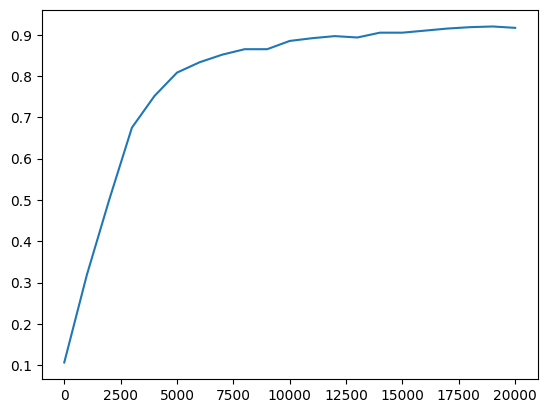

In [11]:
import matplotlib.pyplot as plt
acc_train = np.array(bp_model.acc)
plt.plot(acc_train[:,0],acc_train[:,1])
plt.show()

In [55]:
print(y_output[:5])

[[0.08196781 0.12136221 0.02923792 0.05506404 0.14910178 0.09579632
  0.03541495 0.25464057 0.08882589 0.25604416]
 [0.11633078 0.10832411 0.22754068 0.1552613  0.07164702 0.10843946
  0.14924118 0.0595615  0.11215471 0.04453242]
 [0.08671055 0.12199087 0.0404373  0.06801419 0.13797544 0.07811124
  0.04910022 0.19809411 0.08866548 0.18975228]
 [0.09437407 0.11047539 0.07693596 0.0923914  0.12061178 0.08367766
  0.07230198 0.14078532 0.09457792 0.11268277]
 [0.10876099 0.10763185 0.17406991 0.14117273 0.08057005 0.09513961
  0.12869487 0.06789893 0.10548184 0.0551604 ]]


In [56]:
print(test_labels[:5])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## CIFAR-10数据获取

In [5]:
import pickle
def read_cifar(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1') 
        X = datadict['data']
        Y = datadict['labels']
        X = X.astype("float")
        Y = np.array(Y)
        return X, Y

file_nums = ['1','2','3','4','5']
cifar_train_data = []
cifar_train_labels = []
for i in file_nums:
    file_name = './data/cifar-10-batches-py/data_batch_' + i
    X, Y = read_cifar(file_name)
    cifar_train_data.append(X)
    cifar_train_labels.append(Y)
cifar_train_data = np.concatenate(cifar_train_data)
cifar_train_labels = np.concatenate(cifar_train_labels)
del X, Y
cifar_test_data, cifar_test_labels = read_cifar("./data/cifar-10-batches-py/test_batch")

# 归一化
cifar_train_data = cifar_train_data / 255.0
cifar_test_data = cifar_test_data / 255.0

# one-hot编码
cifar_train_labels = np.eye(10)[cifar_train_labels]
cifar_test_labels = np.eye(10)[cifar_test_labels]

print(cifar_train_data.shape)


(50000, 3072)


## 训练CIFAR-10数据

In [239]:

bp_cifar = BP(3072, [256,128,128,64,64,32,32], 10)
bp_cifar.train(cifar_train_data, cifar_train_labels, epochs=50001+100, learn_rate=0.8, target_e=0.001)

y_output_cifar = bp_cifar.predict(cifar_test_data)
right_cifar = np.sum(np.argmax(y_output_cifar, axis=1) == np.argmax(cifar_test_labels, axis=1))
acc_cifar = right_cifar / len(cifar_test_labels)
print(f"正确率：{acc_cifar}")
print(f"正确样本数：{right_cifar}/{len(cifar_test_labels)}")


正确率：0.3804
正确样本数：3804/10000


### 预测正确率

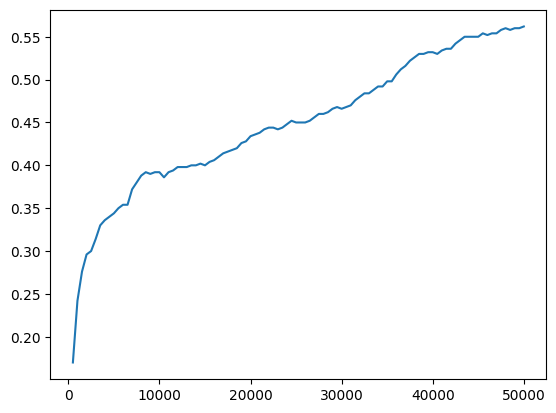

In [240]:
import matplotlib.pyplot as plt
acc_train = np.array(bp_cifar.acc)
plt.plot(acc_train[:,0],acc_train[:,1])
plt.show()